# CIFAR pre-trained model prediction

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Flatten, Dense, Dropout, Convolution2D, Activation, GlobalAveragePooling2D, Rescaling

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


import numpy as np

### Download CIFAR dataset

In [2]:
builder, ds_info = tfds.load('cifar10',
                             split=["train", "test[:40%]", "test[40%:]"],
                             as_supervised=True, 
                             with_info=True)

In [3]:
ds_info.features

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [4]:
ds_train = builder[0]
ds_validation = builder[1]
ds_test = builder[2]

print('train size: ' + str(len(ds_train)))
print('validation size: ' + str(len(ds_validation)))
print('test size: ' + str(len(ds_test)))

train size: 50000
validation size: 4000
test size: 6000


7


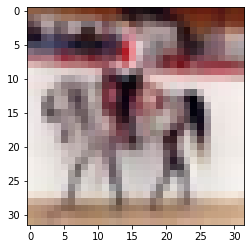

In [5]:
for image, label in ds_train.take(1):
    plt.imshow(image)
    print(int(label))

In [6]:
ds_info.features['image'].shape

(32, 32, 3)

In [7]:
input_size = 96
size = (input_size, input_size)

ds_train = ds_train.map(lambda x, y: (tf.image.resize(x, size, method=tf.image.ResizeMethod.AREA), y))
ds_validation = ds_validation.map(lambda x, y: (tf.image.resize(x, size, method=tf.image.ResizeMethod.AREA), y))
ds_test = ds_test.map(lambda x, y: (tf.image.resize(x, size, method=tf.image.ResizeMethod.AREA), y))

### Verify data

In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

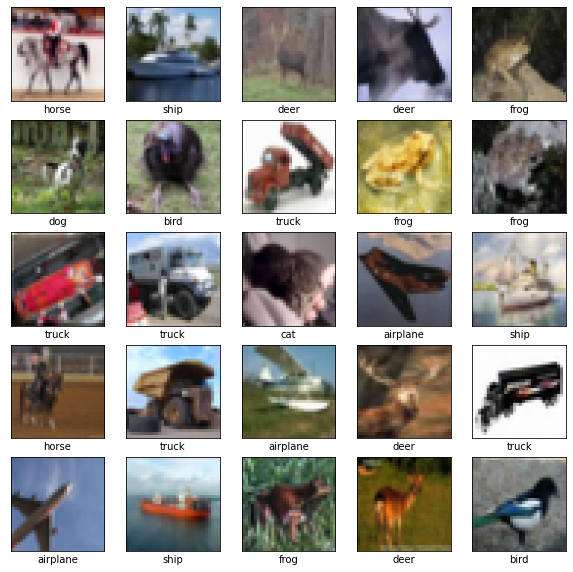

In [9]:
plt.figure(figsize=(10,10))
i = 0
for image, label in ds_train.take(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy().astype('uint8'))
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[label])
    i = i+1
plt.show()

## Define model

In [10]:
NUM_CLASSES = ds_info.features['label'].num_classes
BATCH_SIZE = 32

**Load pre-trained model**

In [11]:
base_model = tf.keras.applications.xception.Xception(weights='imagenet', input_shape=(input_size, input_size, 3), classes = NUM_CLASSES, include_top=False)
#base_model = tf.keras.applications.densenet.DenseNet121(weights='imagenet', input_shape=(input_size, input_size, 3), classes = NUM_CLASSES, include_top=False)
#base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', input_shape=(input_size, input_size, 3), classes = NUM_CLASSES, include_top=False)
#base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', input_shape=(input_size, input_size, 3), include_top = False, classes = NUM_CLASSES)
#base_model = tf.keras.applications.resnet_v2.ResNet50V2(weights='imagenet', input_shape=(input_size, input_size, 3), include_top = False, classes = NUM_CLASSES)

In [12]:
base_model.trainable = False
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 47, 47, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 47, 47, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 47, 47, 32)   0           ['block1_conv1_bn[0][0]'] 

**Define model**

In [13]:
data_augmentation = Sequential(
  [
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
  ]
)

In [14]:
inputs = tf.keras.Input(shape=(input_size, input_size, 3))

#x = data_augmentation(inputs)


x = tf.keras.applications.xception.preprocess_input(inputs)
#x = tf.keras.applications.densenet.preprocess_input(inputs)
#x = tf.keras.applications.inception_resnet_v2.preprocess_input(inputs)
#x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
#x = tf.keras.applications.resnet_v2.preprocess_input(inputs)


# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.
x = base_model(x, training=False)
#x = base_model(inputs, training=False)


x = GlobalAveragePooling2D()(x)


x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

### Train model

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds_validation = ds_validation.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

**Define callbacks to improve the training loop**

In [19]:
def lr_schedule(epoch):
    lr = 1e-3
    if (epoch > 9):
        lr *= 0.1
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

#lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_delta=0.001)

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [21]:
epochs = 12
history = model.fit(ds_train, 
                    epochs=epochs, 
                    validation_data=ds_validation, 
                    callbacks=[lr_callback, es])

Epoch 1/12
1563/1563 [==============================] - 533s 340ms/step - loss: 0.9286 - accuracy: 0.6954 - val_loss: 0.7193 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 2/12
1563/1563 [==============================] - 505s 323ms/step - loss: 0.8064 - accuracy: 0.7374 - val_loss: 0.6943 - val_accuracy: 0.7755 - lr: 0.0010
Epoch 3/12
1563/1563 [==============================] - 598s 382ms/step - loss: 0.8012 - accuracy: 0.7389 - val_loss: 0.6921 - val_accuracy: 0.7707 - lr: 0.0010
Epoch 4/12
1563/1563 [==============================] - 525s 336ms/step - loss: 0.7864 - accuracy: 0.7425 - val_loss: 0.6882 - val_accuracy: 0.7757 - lr: 0.0010
Epoch 5/12
1563/1563 [==============================] - 555s 355ms/step - loss: 0.7894 - accuracy: 0.7415 - val_loss: 0.6952 - val_accuracy: 0.7747 - lr: 0.0010
Epoch 6/12
1563/1563 [==============================] - 554s 355ms/step - loss: 0.7927 - accuracy: 0.7426 - val_loss: 0.6943 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 7/12
1563/1563 [============

### Plot training

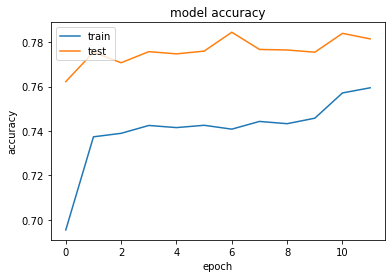

In [22]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

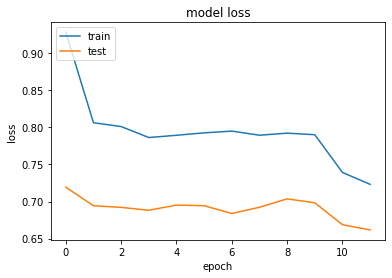

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Fine tuning

In [24]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  132


In [27]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 96, 96, 3)        0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [31]:
fine_tune_epochs = 3
total_epochs =  12 + fine_tune_epochs

history_fine = model.fit(ds_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=ds_validation,
                         callbacks=[es])

Epoch 12/15
1563/1563 [==============================] - 2319s 1s/step - loss: 0.4357 - accuracy: 0.8549 - val_loss: 0.3354 - val_accuracy: 0.8855
Epoch 13/15
1563/1563 [==============================] - 2299s 1s/step - loss: 0.2835 - accuracy: 0.9050 - val_loss: 0.3126 - val_accuracy: 0.8995
Epoch 14/15
1563/1563 [==============================] - 2326s 1s/step - loss: 0.2023 - accuracy: 0.9311 - val_loss: 0.3136 - val_accuracy: 0.9055
Epoch 15/15
1563/1563 [==============================] - 2301s 1s/step - loss: 0.1414 - accuracy: 0.9515 - val_loss: 0.3236 - val_accuracy: 0.9072


## Evaluate model

In [32]:
 model.evaluate(ds_test)

188/188 [==============================] - 59s 305ms/step - loss: 0.3359 - accuracy: 0.9015


[0.3358514904975891, 0.9014999866485596]

In [33]:
y_pred = model.predict(ds_test)
y_test = np.concatenate([y for x, y in ds_test], axis=0)
y_pred_classes = np.argmax(y_pred,axis = 1)
confusion_mtx = tf.math.confusion_matrix(y_test, y_pred_classes)

[[Text(0.5, 0, 'airplane'),
  Text(1.5, 0, 'automobile'),
  Text(2.5, 0, 'bird'),
  Text(3.5, 0, 'cat'),
  Text(4.5, 0, 'deer'),
  Text(5.5, 0, 'dog'),
  Text(6.5, 0, 'frog'),
  Text(7.5, 0, 'horse'),
  Text(8.5, 0, 'ship'),
  Text(9.5, 0, 'truck')],
 [Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'automobile'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')]]

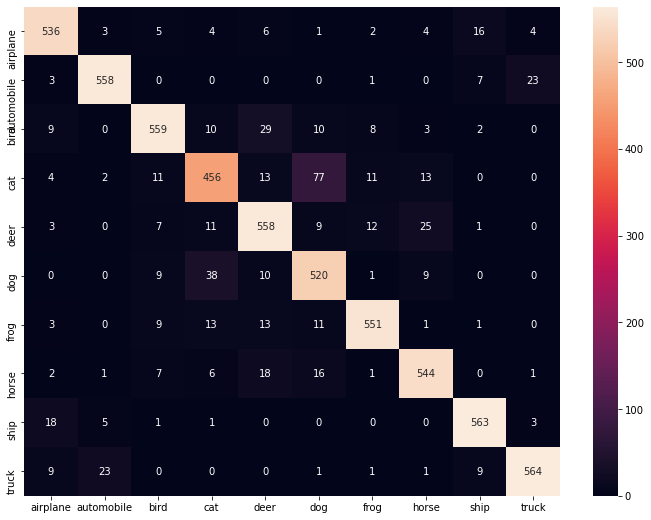

In [34]:
import seaborn as sns

plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
c.set(xticklabels=class_names, yticklabels=class_names)

### Save model

In [35]:
model.save("models/cifar_xception_fine")

INFO:tensorflow:Assets written to: models/cifar_xception_fine/assets


INFO:tensorflow:Assets written to: models/cifar_xception_fine/assets
/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
